<a href="https://colab.research.google.com/github/UAPH451551/PH451_551_Sp24/blob/main/Exercises/01_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1

File name convention: For group 42 and memebers Richard Stallman and Linus <br> Torvalds it would be: <br>
"Exercise1_Goup42_Stallman_Torvalds.pdf".

Submission via blackboard.

In [ ]:
group_name = "insert group name"
group_members = ["name 1",
                 "name 2",
                 "name 3"]

**Chapter 3 – Classification**

# Setup

First, let's **import a few common modules**, ensure MatplotLib plots figures <br> inline, and prepare a function to save the figures. We also check that Python 3.5 <br>
or later is installed (although Python 2.x may work, it is deprecated so we <br>
strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST

Next, let's **import the MNIST dataset** we saw in PythonRefreshers_3. As a <br>
reminder, this is a dataset of **70,000 handwritten characters stored in 28x28** <br>
**pixel images**.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

We'll need the `data` of 28x28 pixel images and `target` of number labels 0-9 <br>
for this exercise.

In [ ]:
X, y = mnist["data"], mnist["target"]

X is a pandas dataframe but we'll eventually want to work with a numpy array of <br>
the pixel values, which we can get later using `X.values`.

In [ ]:
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(70000, 784)


In [ ]:
y.shape

(70000,)

In [ ]:
# the images are 28x28 pixels
28 * 28

784

We can create a function that implements the `imshow` function from matplotlib <br>
so that we can visualize the handwritten characters.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Here's an example of how we would use the function we just made. Note how it <br>
requires a numpy array which we get using `.values`. We can use `%matplotlib` <br>
`inline` to get our plots to show up below the current cell without having to <br>
repeatedly use `plt.show()`.

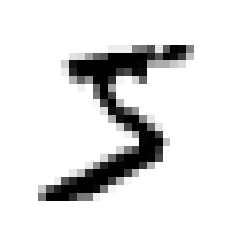

In [ ]:
%matplotlib inline

# to get the values of the dataframe X, call X.values.
# X.values[0] gives the pixel values for the first image
plot_digit(X.values[0])

Don't worry about how the function `plot_digits` below works. This is just <br> one way we can visualize a subset of our X values (handwritten characters).

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

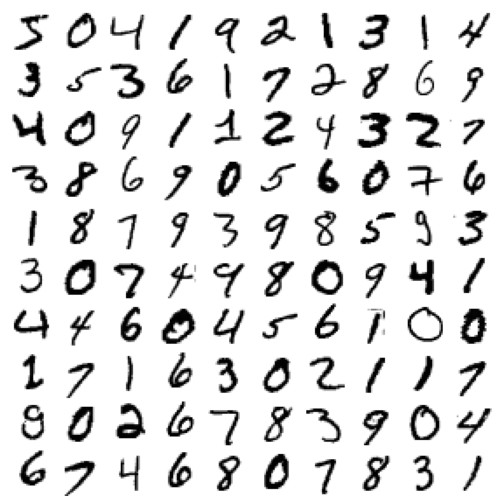

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100].values
plot_digits(example_images, images_per_row=10)
plt.show()

Notice how **the type of our labels is a string by default**, but we can convert <br>
this to a collection of integers instead.

In [ ]:
print(type(y[0]))
print(y[0])

<class 'str'>
5


In [ ]:
y = y.astype(np.uint8)
type(y[0])

numpy.uint8

In chapter 1 you were introduced to the idea of a **train** and **test** set. Since <br>
**this dataset is already randomly shuffled**, we can get our train and test sets by <br>
just selecting the **first 60,000 characters and labels for training** and the **last** <br>
**10,000 for testing**.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier
Let's train a classifier to predict whether a given digit is a 5 or not. <br>

To start with, we'll create a sub-set of our data that is either True or False <br>
depending on whether the label value is 5. **Many functions can treat True and <br> False as 0 or**
**1 values**.

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
print(y_train_5[:10]) # Visualize first 10 samples of the training set

0     True
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: class, dtype: bool


In [ ]:
print(y_test_5[:10]) # Visualize first 10 samples of the test set

60000    False
60001    False
60002    False
60003    False
60004    False
60005    False
60006    False
60007    False
60008     True
60009    False
Name: class, dtype: bool


## Task 1: SGD Classifier

SGD (Stochastic Gradient Descent) Classifier is a linear model which gradually <br>
attempts to decrease its loss by evaluating the way that changes made to the <br>
model weights affect the gradient of the loss value.

1) Create an [SGD Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) `sgd_clf` with the following hyperparameters:<br>
- `max_iter=1000`: This sets the maximum number of times the model will see <br>
the whole dataset during training. <br>
- `tol=1e-3`: This sets a stopping condition that, when your loss is greater <br>
than your best loss minus tol, it will stop training.<br>
- `random_state=42`: This will ensure that you will get the same results every <br>
time you run the training algorithm.<br>

2) Fit the classifier by calling its `fit` function with `X_train` and <br> `y_train_5` as the parameters. This might take a while.

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
sgd_clf =

In [ ]:
# fit the sgd_clf

In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

In [ ]:
# let's test the model on an example. Feel free to play around and try more.

In [ ]:
sgd_clf.predict(X_test[0:1])

array([False])

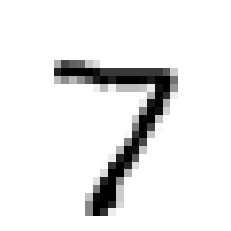

In [ ]:
plot_digit(X_test[0:1].values)

## Task 2: Cross Validation of SGD Classifier

1) Calculate the [cross-validation score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) of the `sgd_clf` classifier with the <br>
train data. Use `cv=3` and `scoring="accuracy"`.    

2) a) Explain what cross validation is. Hint: check chapter 2 of the textbook.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# 1)
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
# cross val score


In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

### Double click this:

Enter your answer to 2) a) below this:


Here is some code for a [stratified k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

2) b) Explain stratified cross validation. Hint: check chapter 2 of the <br> textbook.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.values[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.values[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
# your answer goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

### Double click this:

Enter your answer to 2) b) below this:


In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your answer goes above this

# Never 5 Classifier
This classifier always predicts 0 or False. Don't worry too much about the code <br>
below for now. The important things are that **this is a class or type of object** <br>
**in python that has an appropriate type to be used by sklearn functions**. What <br>
it's doing is just **creating a list of 0's of the same size of your input** or X <br>
values and returning that as its solutions.

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Task 3
Explain why the "never 5 classifier" still has such "high" scores. Hint: think <br>
about True (1) and False (0) labels.

In [ ]:
# your answer goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

### Double click this:

Enter your answer to 3) below this:


In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your answer goes above this

Back to the real classifier: `sgd_clf`

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

## Task 4
Calculate the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for
- predicted values (true y values and predicted y values)
- perfect predictions (Hint: use only true values)

Explain what the entries of the confusion matrix mean.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
# confusion matrix for predicted values


In [ ]:
# confusion matrix for perfect predictions


### Double click this:

Enter your exaplanation for 4) below this:


In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

## Task 5
Calculate precision and recall scores for training and predicted values. <br>
Precision = TP / (TP + FP) <br>
Recall = TP / (TP + FN)

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

## Task 6
Using the values from the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), calculate
- the rate of false positives, true positives, false negatives, true negatives
- accuracy (TP + TN) / (TP + TN + FN + FP)
- precision

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

## Task 7
Calculate the f1 score. <br>
F1 = (2 \* precision \* recall) / (precision + recall)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

## Task 8
Explain what the scores in task 6 and 7 (accuracy, precision, f1) describe. <br>
**Do not just copy formulas**; explain their meaning.

In [ ]:
# your answer goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

### Double click this:

Enter your answer to 8) below this:


In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your answer goes above this

# Setting a Threshold on the Prediction

Models will often have some mathematical function which determines a so-called <br>
confidence score. This score can be thought of as a likelihood of predicting <br>
a particular value correctly. Sometimes these are percentages and other times <br>
these are some continuous value.

In [ ]:
some_digit = X.values[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/anaconda3/envs/delay_line_detector/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

We can also set a **threshold for confidence** scores that says we **only consider a** <br>
**prediction if it's made with enough "confidence"**.

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

These **confidence scores can also be generated using** the decision_function <br>
method of **cross_val_predict()**.

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

The **precision_recall_curve compares precision and recal values at certain** <br>
**confidence thresholds**. That is, if we require the model make a prediction with <br>
a certain degree of confidence, how does that affect our precision and recall.

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

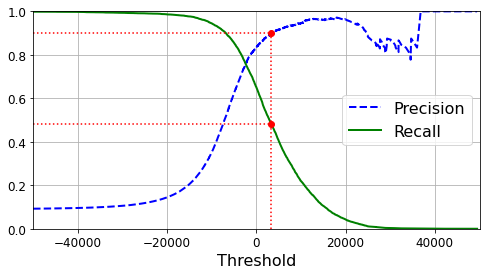

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

Another way to evaluate precision and recall is just plotting them against <br>
one another. **Notice the dashed red box**. **The right side shows what our recall** <br>
**performance is at a precision of 0.9 out of a maximum of 1**.

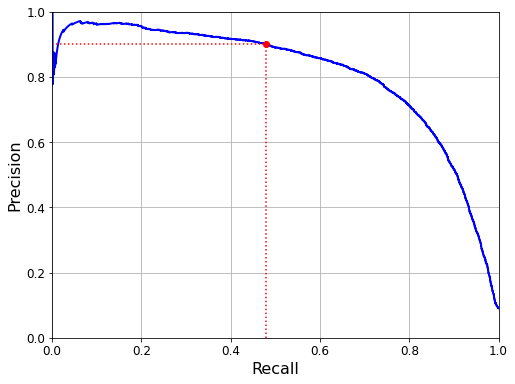

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

Let's check what our threshold value is at 0.9 precision.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

3370.0194991439557

We can also analyze our performance at the region above that threshold.

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

We can now go on to calculate the [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). <br>
For a good explanation see also [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) or the Statistics_1 notebook.

Basically instead of plotting measures like precision and recall as a function <br>
of the threshold, we plot the true positive rate (recall) vs the false positive <br>
rate (fall-out).

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

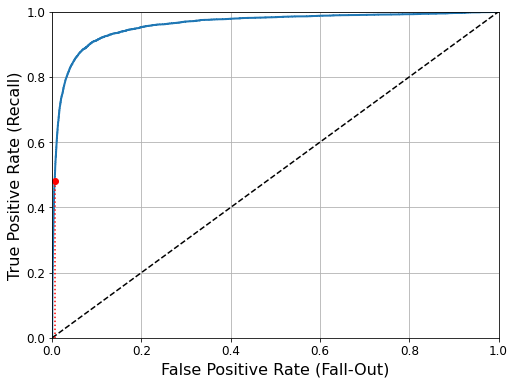

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

The area under the curve (auc) is a measure of how good the model is.

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's compare the SGD model with another model. This other model is called a <br>
"random forest" classifier. **We'll cover these more in depth in the coming weeks** <br>
but, **for now, just think of this as some other model of interest**.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

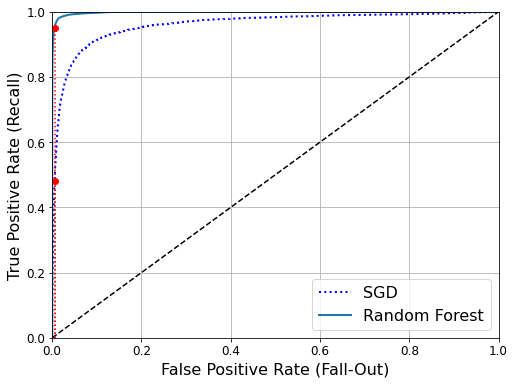

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Task 9

Interpret the results from above and answer the following questions: <br>
- Which model performed better? SGD or Random Forests <br>
- Explain what information above you used to reach this conclusion.

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

### Double click this:

Enter your answer to 9) below this:


In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

# Textbook exercises

**Exercise 1**

Feel free to play around with this question.<br>
Try to build a different classifier.<br>

__Hint__: the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) works quite well for this task. Good hyperparameters <br>
are `{'n_neighbors': 4, 'weights': 'distance'}`

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# your code goes below
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [ ]:
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
# your code goes above this

**Exercise 2**
(Optional)

Write a function that can shift an MNIST image in any direction (left, right, <br>
up, or down) by five pixels. Then, for each image in the training set, create <br>
four shifted copies (one per direction) and add them to the training set.<br> Finally, train your best model on this expanded training set and measure its <br>
accuracy on the test set. You should observe that your model performs even<br> better now! This technique of artificially growing the training set is called <br>
data augmentation or training set expansion.

# Exercise 2 Solution

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

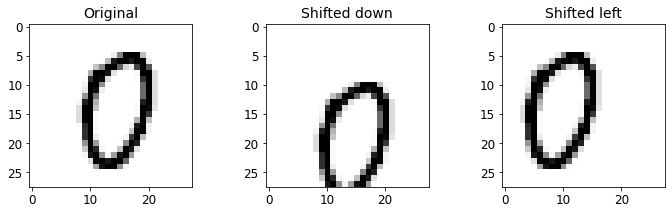

In [ ]:
image = X_train.values[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train.values]
y_train_augmented = [label for label in y_train.astype(np.int8)]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train.values, y_train.astype(np.int8)):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [{
"n_neighbors": (3,4),
"weights": ["uniform", "distance"]
}]

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(knn_clf, param_grid)
grid_search.fit(X_train.values, y_train.astype(np.int8))

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': (3, 4),
                          'weights': ['uniform', 'distance']}])

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test.values)
accuracy_score(y_test, y_pred)

0.9763